In [17]:
from clustering_tool.autoencoder import *
from clustering_tool.datasets import *
from clustering_tool.train import *
from clustering_tool.clusterer import *
from clustering_tool.model import *

In [10]:
device='cpu'
if torch.cuda.is_available():
    device='cuda'

In [11]:
device

'cpu'

In [22]:
def train_ae(dataset_name, num_clusters, emb_name):
    print('Training on ', dataset_name, emb_name)
    dataloader = read_saved('data/{}_{}.npy'.format(dataset_name, emb_name), 'data/{}_label.npy'.format(dataset_name), device=device)
    input_size = dataloader.dataset[0]['input'].shape[0]
    encoder=createEncoder(input_size).to(device)
    decoder=createDecoder(input_size).to(device)
    losses = {'decoder_loss': constant_loss_weight_fn(1.0)}
    start_lr = 3e-3
    end_lr = 1e-4
    num_epochs = 10
    gamma = (end_lr / start_lr) ** (1/num_epochs)
    train_autoencoder(encoder, decoder, dataloader, losses, start_lr, gamma=gamma, num_epochs=num_epochs)
    
    cluster_centers = init_cluster_centers(encoder, dataloader, num_clusters)
    clusterer = XieClusterer(torch.tensor(cluster_centers, requires_grad=True, device=device), trainable_centers=True)
    model = DeepClusteringModel(encoder, clusterer, decoder=decoder)
    torch.save(model, 'models/{}_{}_ae.pt'.format(dataset_name, emb_name))
    

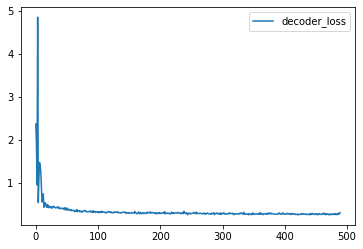

100%|██████████| 10/10 [00:23<00:00,  2.36s/it]



Average: 6764.178444778471 Best:  6764.099735783981


/Users/17aleshka/opt/anaconda3/envs/torch_env/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app


In [23]:
train_ae('SearchSnippets', 8, 'word2vec_md_weighted')

In [ ]:
datasets_n_clusters = [('SearchSnippets', 8), ('Biomedical', 20), ('StackOverflow', 20)]
emb_types = ['tf_idf', 'word2vec_md_avg', 'word2vec_lg_avg', 'word2vec_md_weighted','word2vec_lg_weighted', 
             'bert_avg', 'bert_cls', 'bert_pooler', 'bert_pooler']
for dataset_name, n_clusters in datasets_n_clusters:
    for emb_type in emb_types:
        train_ae(dataset_name, n_clusters, emb_type)